# L02 - Clustering

NOTE: 
- To execute all code and see the results in COLAB, click on menu "Runtime" -> "Execute all"  or press CTRL-F9
- To execute a single cell, press CTRL-Return (or SHIFT-Return to jump to next cell afterwards)



## Introduction

### What is Clustering?

In Clustering, we are given a set of datapoints, e.g. biological probes, properties of houses, or health data of cancer patients (temperature, blood samples etc.). Our goal is to find subgroups of these datapoints that are similar to each other. Grouping the datapoints can help us to better «understand» the data. For instance, if we identify a group of similar cancer patients, we might be able to find a pattern that is related to the origin of their cancer.

### Example

Assume we have the following data where each sample consists of two measurements: height and weight.




<div>

</div>

Then we might separate the data in two clusters as follows:

<div>

</div>

Or we can separate the data into 5 groups, as follows:


</div>


We can now give a more formal definition of the clustering task:

## Definition: Clustering

Given a set of data points $X = \{x^{(1)}, x^{(2)}, \ldots, x^{(m)}\}$ where each data point $x^{(i)}$ consists of $n$ features: $x^{(i)} = (x_{1}^{(i)}, \ldots, x_{n}^{(i)}) \in \mathbb{R}^{n}$, and a distance measure $D$, a **clustering** is a collection of subsets of $X$ (called "clusters"). The clusters are created with the goal that samples in the same cluster are similar, i.e. have a small distance according to the distance measure $D$, whereas samples belonging in different clusters have a large distance.


For instance, we might have $m$ patients and for each patient we have $n$ measurements corresponding to their age, weight, height, and some blood analysis results.

Note that in clustering, we are dealing with *unlabeled data*, meaning we only have the raw data points with no label assigned to them. Methods utilizing unlabeled data are also called *unsupervised machine learning algorithms*.

## The K-Means Algorithm

One of the most prominent clustering algorithms is the k-Means algorithm. The main idea is shown in the following [video](https://www.youtube.com/watch?v=JqONmLsRs8Y).

The following pseudo-code depicts the basic principles of k-Means:

**Input**:
* $X = \{x^{(1)}, \ldots, x^{(m)}\}$ set of $m$ data points
* the number of clusters $k$

**Output**:
* a set of $k$ centroids $\{c_1, \ldots, c_k\}$

**Algorithm**
```
choose k initial centroids c_1, ..., c_k

  REPEAT

  compute closest centroid c_i for each data point and "assign" data point to that centroid

  FOR EACH centroid c_i
    A_i = set of data points currently assigned to c_i
    m_i = mean of all data points in A_i (see below)
    c_i = m_i
  END FOR

  UNTIL stop-criterion is met

RETURN c_1, ..., c_k as the centroids of the k clusters

```

Computing the mean of all data points assigned to $c_i$:
$m_i = \frac{1}{|A_i|}\sum_{x^{(i)} \in A_i} x^{(i)}$


We call each loop of assigning data points and re-calculating centroids an *iteration*.

For the distance $D$ between two data points, we use the Euclidean distance (also called L2-norm):

$d(x, y) = \sqrt{\sum_{j = 1}^{m} (x^{(j)} - y^{(j)})^{2}}$


In the following code, you find a basic implementation of k-Means.

We first generate some data points:

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

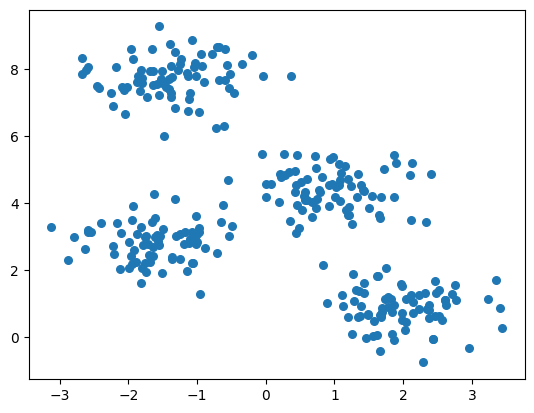

In [2]:
X, cluster_label = make_blobs(
    n_samples=300,  # number of data points m
    n_features=2,   # number of features n
    centers=4,      # true number of clusters (unknown)
    cluster_std=.6, # how close points in the same cluster are together
    random_state=0,
)

plt.scatter(X[:, 0], X[:, 1], s=30)

Note that we have created data points with $m=2$ features. This is only for illustration of the algorithm - real world data usually has many more features, but these cannot be plotted in 2D.

Next, we implement the k-Means algorithm:

In [3]:
import numpy as np

from sklearn.metrics import pairwise_distances

In [4]:
class MyKMeans:
    def __init__(self, k, random_seed=0):
        self.k = k
        self.centroids = None  # placeholder

        self.random_seed = random_seed
        self.rng = np.random.default_rng(self.random_seed)
    
    def fit(self,X):

        m, n = X.shape

        # select initial centroids from data
        self.centroids = X[self.rng.choice(np.arange(m), self.k)]

        cluster_index = self.predict(X)
        new_centroids = self._calc_centroids(X, cluster_index)
        while not np.allclose(self.centroids, new_centroids):
            self.centroids = new_centroids
            cluster_index = self.predict(X)
            new_centroids = self._calc_centroids(X, cluster_index)

        return self
    
    def predict(self,X):
        distances = pairwise_distances(X, self.centroids, metric="euclidean")
        return np.argmin(distances, axis=1)
    
    def _calc_centroids(self, X, cluster_index):
      return np.array([
          np.mean(X[cluster_index == i], axis=0)
          for i in range(self.k)
      ])


We can now run the k-Means algorithm on the data by setting the desired number of clusters $k$:

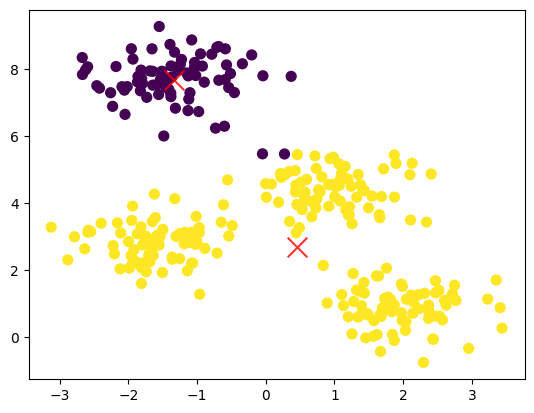

In [5]:
k = 2

my_kmeans = MyKMeans(k=k)
my_kmeans.fit(X)

cluster_assignment = my_kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=cluster_assignment, s=50, cmap="viridis")
plt.scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1], c="red", marker='x', s=200, alpha=.8)

**TASK: run k-Means with $k = 3,4,5$.**

We now explain the main steps of the algorithm in more detail:

## Selection of Initial Centroids

There are two simple and straightforward ways to select the initial centroids $c_1, \ldots, c_k$ at the beginning of the algorithm:

* random points: randomly select $k$ points in $\mathbb{R}^n$
* random data points: randomly select $k$ points from $X$ as initial centroids, meaning that the initial centroids are *data points*.

*Question*: Which method was used in our implementation above?
* Random data points where used in the given code example.

## Stop-Criterion

There are many potential stopping criteria for the k-Means algorithm. The most obvious is when the centroids do not change anymore. This also means that the assignment of data points to centroids does not change anymore (it is "stable"), and we can output the result.

However, for large data sets we cannot expect that we will reach such a stable assignment in reasonable time. Instead, we can hope that after some time the assignment will only change "slightly", which we can assess with any of the following criteria:

* stop when the coordinates of the centroids change only very little from one iteration to the next
* stop when only very few data points are re-assigned to a different centroid in a new iteration

Apart from this, we can also use time-boxed criteria:

* stop after a fixed number of iterations (e.g. after 20-50 iterations)
* stop after a certain time for the entire computation has elapsed (e.g. after 1 minute)

**Question**: Which criterion was used in our implementation above?
* stopping when the coordinates of centroids only change very little.

## Quality of a k-Means Clustering

If we randomly select the initial centroids, then the resulting clustering will depend on this selection. The following code runs k-Means on the same data with different randomly selected initial centroids:

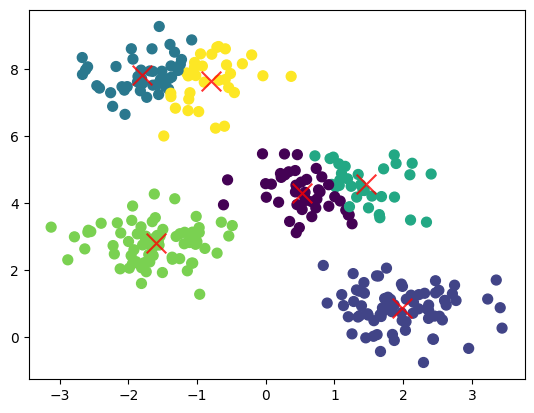

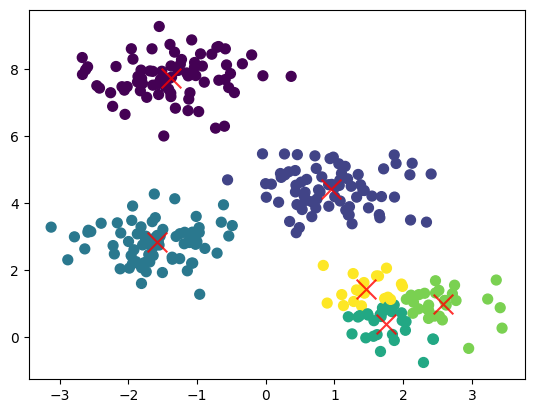

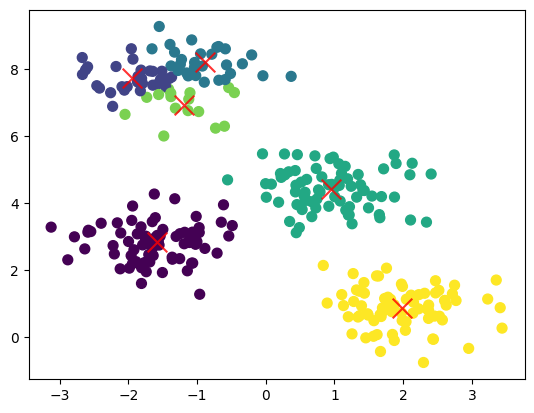

In [10]:
random_seeds = [
    0xabeeffed,
    0xcafebcde,
    0xd01f00d,
]

k = 6

for seed in random_seeds:
  km = MyKMeans(k=k, random_seed=seed)
  km.fit(X)
  ixs = km.predict(X)
  plt.scatter(X[:, 0], X[:, 1], c=ixs, s=50, cmap="viridis")
  plt.scatter(km.centroids[:, 0], km.centroids[:, 1], c="red", marker='x', s=200, alpha=.8)
  plt.show()

**Task: Rerun the above code with different values of $k$ and different random seeds.**

## Quality of k-Means Clustering (contd.)

Thus, different initial centroids in k-Means might result in very different clusterings. For this reason, we need a way to quantify the *quality* of a clustering. This is typically done by using the *potential function* $\Phi$ which measures the squared distance between each data point and its closest centroid:

Let $C = \{c_1, \ldots, c_k\}$ a set of $k$ centroids, then
$\Phi(C, X) = \sum_{i = 1}^{m} min_{c \in C} d(x^{(i)}, c)^{2}$.

In practice, one will run k-Means several times with different randomly selected initial centroids, and then choose the "best" clustering that was obtained.

## How to choose the number of clusters $k$

If we know how many clusters we are expecting in the data - e.g. because we want to have a specific number of clusters for subsequent processing, or we know the correct number from domain expertise - then we can just select the proper value for $k$.

However, in most cases, clustering aims to discover the hidden structure in the data and it is not clear what the "correct" number of clusters is. In fact, in many cases different values for $k$ are reasonable. For instance, in the following picture either $2$ or $6$ clusters seem very obvious, but also $4$ clusters might be reasonable:


</div>


In this case we can use the **Elbow Method** to determine a good value for $k$. In this method, we run k-Means with different values of $k$ and plot the value of the potential function $\Phi$ for each value of $k$.


Then the value of k at the point where the slope of the curve significantly decreases (or where the elbow would be if we imagine an arm along the courve) is a good choice for the number of clusters. This is because afterwards the improvements are only marginal. 

Applying this approach in the example below, we would set $k=4$. 

In [7]:
def potential(X, centroids):
  dists = pairwise_distances(X, centroids, metric="euclidean")
  dist_to_assigned = np.min(dists, axis = 1)
  return dist_to_assigned @ dist_to_assigned

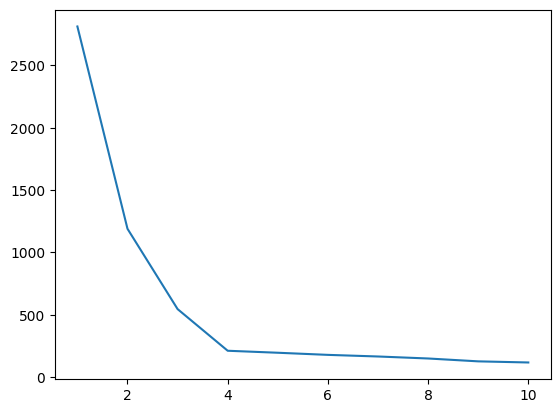

In [8]:
k = np.arange(1, 11)
phi = np.zeros_like(k)
for ix, k_ in enumerate(k):
  km = MyKMeans(k=k_)
  km.fit(X)
  phi[ix] = potential(X, km.centroids)

plt.plot(k, phi)

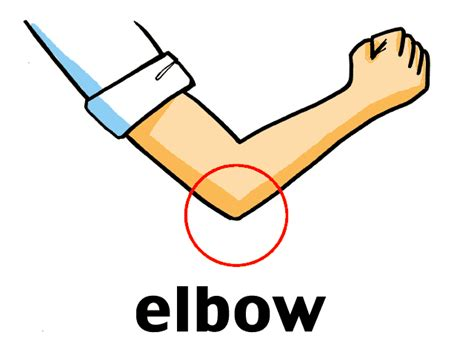

## Runtime Complexity

Note that solving the k-Means clustering problem - i.e. finding $k$ centroids that minimize the sum of squared distance to all data points - is NP-hard (see https://cseweb.ucsd.edu/~avattani/papers/kmeans_hardness.pdf).

We will now analyze the runtime of the k-Means algorithm for the simplest variant, where we select $k$ random points as initial centroids.

Assume we are given $m$ data points with $n$ features. Assume further that k-Means stops after $L$ iterations. Then the **runtime of k-Means is $\mathcal{O}(Lknm)$.

* In the first step, we randomly select $k$ initial centroids with $n$ dimensions each: this step will run in $\mathcal{O}(kn)$.
* In each of the $L$ iterations, we compute the distance between each data point and each centroid. The euclidean distance computation takes $\mathcal{O}(n)$. There are $m$ data points and $k$ centroids, thus we need total time $\mathcal{O}(knm)$ per iteration.
* There are $L$ iterations, each taking $\mathcal{O}(knm)$, leading to a total runtime of $\mathcal{O}(Lknm)$.

## Trivia: Who invented the k-Means algorithm? [Not Part of Exam]

The term "k-Means" was probably first used by James MacQueen in a working paper from 1965, and in his [publication](https://www.cs.cmu.edu/~bhiksha/courses/mlsp.fall2010/class14/macqueen.pdf) from 1967. This publication has more than 35'000 citations. The method itself has, however, been known before. A variant was described in a paper draft by Stuart Lloyd circulated at the Bell Laboratories already in 1957. Due to some incompleted numerical calculations, this paper was only published in 1982. For a more detailed discussion of the origins of k-Means, see ["A history of the k-Means algorithm"](http://www.modulad.fr/dac/Slides/Bock/Ahistoryofthek-means.pdf) by Hans-Hermann Bock.

## Trivia: What is the difference between k-Means and k-NN?

k-Means is sometimes confused with k-NN, which stands for [k-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). Note that these are totally different algorithms: While k-means is used for clustering unlabeled data, k-NN is a supervised learning algorithm used for classification.

##DBSCAN

Another clustering algorithm that works very different from k-Means Clustering is DBSCAN (short for "Density-based Spatial Clustering of Applications with Noise")

DBSCAN is explained in the following video: https://www.youtube.com/watch?v=_A9Tq6mGtLI 

In the following, we briefly summarize now how DBSCAN works. 

DBSCAN has two parameters:  

* *minPts*: The minimum number of points (a threshold) clustered together for a region to be considered dense
* $\epsilon$: A distance measure to define the neighborhood of any point. Point x is reachable from point y iff distance(x,y) < $\epsilon$

Using these parameters, we can split up the input datapoints into three types of points:
 

* Core point: has at least minPts points within distance ε from itself (e.g. point A)
* Border point (B,C): has at least one core point within distance ε (e.g. point B, C)
* Noise point: a point that is neither a core nor a border point (e.g. point N)



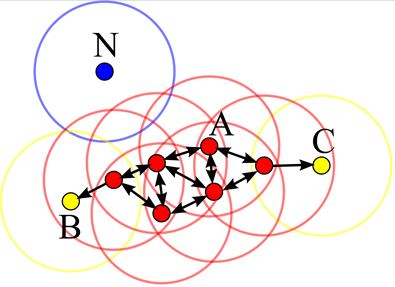

DBSCAN Algorithm



1. Select an unprocessed point P
2. If P is not a Core Point (i.e. there are less than *minPts* points within range $\epsilon$), then classify P as noise and go back to Step 1 
3. Otherwise, if P is a core point, a new cluster is formed as follows: 
* Assign all neighbors of P (i.e. all points within distance $\epsilon$ from P) to the new cluster
* Repeat previous step for all newly-assigned neighbors
4. Go back to Step 1
5. Continue algorithm until all data points have been processed


The naive implementation of this algorithm has running time $O(m^2)$ for m samples. However, this can be reduced to $O(m log m)$ with a data structure that allows to  retrieve all neighbors of a point x in time O(log m). Note that this only works if we assume that there are on average at most log m neighbors for each point.

## Further Reading [Not part of Exam]


* In-depth description and implementation of DBSCAN: https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/
* Original Paper on DBSCAN: Ester et al, 1996: "A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise". https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf 



## Moodle Quiz

**Next Step: Please answer the quizzes on Moodle now.**